In [5]:
import random

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import RMSprop

from model import LSTMModel

Read Preprocessed Dataset 

In [7]:
path = './data/knn_clean_data.csv'
df = pd.read_csv(path)
# select relevant features
moods = df[['ID', 'time', 'mood']]
moods.sort_values(by=['time'], inplace=True)
# convert date into int
moods['time'] = pd.to_datetime(moods['time'])
moods['time'] -= min(moods['time'])
moods['time'] = moods['time'].dt.days
# process id and mood
moods = pd.get_dummies(moods, columns=['ID'])
moods['mood'] = moods['mood'].round().astype(int)
print(moods['mood'].value_counts())


7    639
8    315
6    268
5     24
9     12
4      8
3      2
Name: mood, dtype: int64


C:\Users\china\AppData\Local\Temp\ipykernel_7512\2028710308.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods.sort_values(by=['time'], inplace=True)
C:\Users\china\AppData\Local\Temp\ipykernel_7512\2028710308.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moods['time'] = pd.to_datetime(moods['time'])
C:\Users\china\AppData\Local\Temp\ipykernel_7512\2028710308.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [9]:
# define hyper-parameters
hidden_size = 128  # 隐藏层维度
num_layers = 2  # LSTM层数
output_size = 10  # 输出维度
num_epochs = 3000  # 迭代次数
learning_rate = 1e-2  # 学习率
max_grad_norm = 5.0

seq_length = 7
batch_size = 128
step = 3
# generate dataset
ids = df['ID'].unique()
id_moods = []
for uid in ids:
    uid = 'ID_' + uid
    id_mood = moods[moods[uid] == 1]
    id_moods.append(id_mood)
# remove data that is not continuous
id_moods[0] = id_moods[0][2:]

dataset = []
for id_mood in id_moods:
    id_dataset = [id_mood[i:i + seq_length + 1] for i in range(0, len(id_mood) - seq_length, step)]
    id_dataset = [df.to_numpy() for df in id_dataset]
    dataset += id_dataset

print('dataset size:', len(dataset))
# split it into train set and test set.
random_indices = random.sample(range(len(dataset)), k=int(len(dataset) / 5))
train_set = []
test_set = []

for i in range(len(dataset)):
    if i in random_indices:
        test_set.append(dataset[i])
    else:
        train_set.append(dataset[i])
print('train set size:',len(train_set))
print('test set size:', len(test_set))

X_train = [element[:seq_length] for element in train_set]
y_train = [element[seq_length:][0][1:2] for element in train_set]
X_test = [element[:seq_length] for element in test_set]
y_test = [element[seq_length:][0][1:2] for element in test_set]
# convert them into Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset size: 370
train set size: 296
test set size: 74


In [10]:
# 定义参数
input_size = X_train.shape[-1]  # 输入维度
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 创建模型并将其移动到设备上
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
# 定义损失函数和优化器
criterion = CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=learning_rate)
optimizer = RMSprop(model.parameters(), lr=learning_rate)

loss_history = []
accuracy_history = []
batch_num = len(X_train) // batch_size
# 训练模型
for epoch in range(num_epochs):
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)
        if len(targets) < batch_size:
            continue
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        total_loss += loss.item()
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        # 剪枝
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        
    total_loss = total_loss / batch_num
    loss_history.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}')
        # 模型评估
        with torch.no_grad():
            correct = 0
            total = 0
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i + batch_size].to(device)
                targets = y_test[i:i + batch_size].to(device)
                targets = targets.transpose(0, 1)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                # print(predicted)
                # print(targets)
                total += targets.size(1)
                correct_matrix = (predicted == targets)
                correct += (predicted == targets).sum().item()
            print(f'Accuracy on test set: {100 * correct / total:.2f}%')
            accuracy_history.append(100 * correct / total)
    

Epoch [10/3000], Loss: 1.1388
Accuracy on test set: 56.76%
Epoch [20/3000], Loss: 1.1324
Accuracy on test set: 56.76%
Epoch [30/3000], Loss: 1.1303
Accuracy on test set: 56.76%
Epoch [40/3000], Loss: 1.1291
Accuracy on test set: 56.76%
Epoch [50/3000], Loss: 1.1284
Accuracy on test set: 56.76%
Epoch [60/3000], Loss: 1.1279
Accuracy on test set: 56.76%
Epoch [70/3000], Loss: 1.1275
Accuracy on test set: 56.76%
Epoch [80/3000], Loss: 1.1273
Accuracy on test set: 56.76%
Epoch [90/3000], Loss: 1.1271
Accuracy on test set: 56.76%
Epoch [100/3000], Loss: 1.1270
Accuracy on test set: 56.76%
Epoch [110/3000], Loss: 1.1269
Accuracy on test set: 56.76%
Epoch [120/3000], Loss: 1.1285
Accuracy on test set: 56.76%
Epoch [130/3000], Loss: 1.1268
Accuracy on test set: 56.76%
Epoch [140/3000], Loss: 1.1268
Accuracy on test set: 56.76%
Epoch [150/3000], Loss: 1.1267
Accuracy on test set: 56.76%
Epoch [160/3000], Loss: 1.1267
Accuracy on test set: 56.76%
Epoch [170/3000], Loss: 1.1513
Accuracy on test s

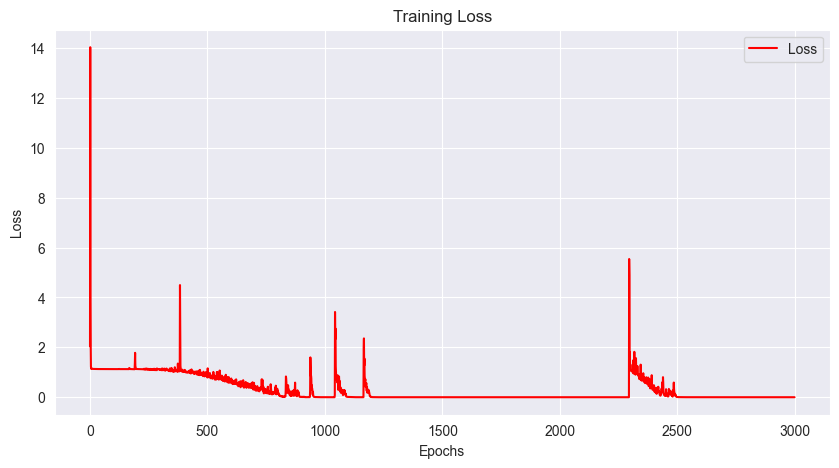

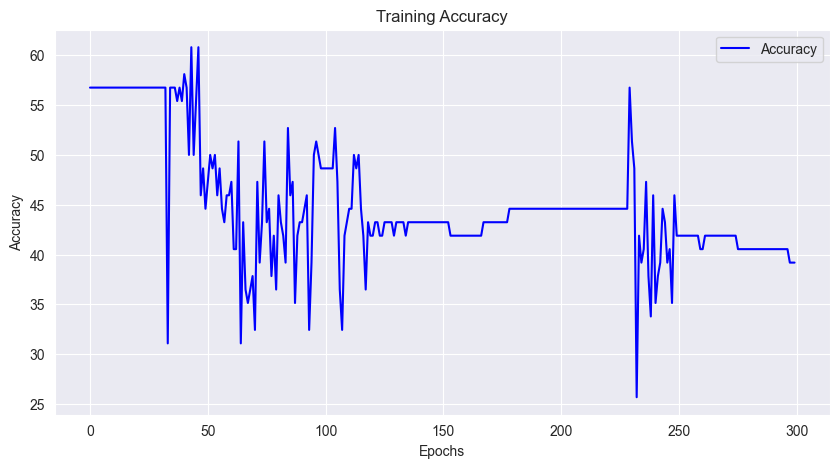

In [11]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'r', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 绘制准确率图像
plt.figure(figsize=(10, 5))
plt.plot(accuracy_history, 'b', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()